In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings

Download and load data

In [68]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')

url = 'https://www.dropbox.com/s/29a48lv3j5ybcvw/pieman2_htfa.pkl?dl=1'

fname = os.path.join(datadir, 'pieman2_htfa.pkl')
if not os.path.exists(fname):
    with open(fname, 'wb') as f:
        data = requests.get(url).content
        f.write(data)

with open(fname, 'rb') as f:
    data = pickle.load(open(fname, 'rb'))

conditions = list(data['weights'].keys())

Load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., 700\}$ components

In [71]:
def group_pca(data, n_components=None, fname=None):
    if fname is not None:
        if os.path.exists(fname):
            with open(fname, 'rb') as f:
                return pickle.load(f)
    
    pca = PCA(n_components=n_components)
    
    x = dw.stack(data)
    y = pca.fit_transform(x)

    y = dw.unstack(pd.DataFrame(index=x.index, data=y))

    if fname is not None:
        with open(fname, 'wb') as f:
            pickle.dump((y, pca), f)
    
    return y, pca

In [79]:
scratch_dir = os.path.join(basedir, 'data', 'scratch')
if not os.path.exists(scratch_dir):
    os.makedirs(scratch_dir)

reduced_data = {'full': {}}
models = {'full': {}}
max_components = data['weights']['intact'][0].shape[1]

n_parts = 3
for i in range(n_parts):
    reduced_data[f'pt{i}'] = {}
    models[f'pt{i}'] = {}

for c in conditions:
    reduced_data['full'][c] = {}
    models['full'][c] = {}

    for i in range(n_parts):
        reduced_data[f'pt{i}'][c] = {}
        models[f'pt{i}'][c] = {}
    
    chunk_size = data['weights'][c][0].shape[0] // n_parts

    for n in tqdm(range(3, max_components + 1)):
        # full time range
        fname = os.path.join(scratch_dir, f'pca_full_{c}_{n}.pkl')
        reduced_data['full'][c][n], models['full'][c][n] = group_pca(data['weights'][c], n_components=n, fname=fname)
        
        # chunked time range
        for i in range(n_parts):
            fname = os.path.join(scratch_dir, f'pca_pt{i + 1}_of_{n_parts}_{c}_{n}.pkl')
            chunk_start = i * chunk_size
            if i < n_parts - 1:                
                chunk_end = (i + 1) * chunk_size
            else:
                chunk_end = data['weights'][c][0].shape[0]
            
            next_chunk = [x.iloc[chunk_start:chunk_end] for x in data['weights'][c]]
            reduced_data[f'pt{i}'][c][n], models[f'pt{i}'][c][n] = group_pca(next_chunk, n_components=n, fname=fname)


 23%|██▎       | 160/698 [10:20<1:03:08,  7.04s/it]

In [ ]:
def accuracy(train, test):
    train = np.mean(np.stack(train, axis=2), axis=2)
    test = np.mean(np.stack(test, axis=2), axis=2)
    dists = cdist(train, test, metric='correlation')
    
    labels = np.argmin(dists, axis=1)
    return np.mean([i == d for i, d in enumerate(labels)]) - 1 / len(labels)

In [ ]:
def cross_validation(data, n_iter=10, fname=None):
    if fname is not None:
        if os.path.exists(fname):
            with open(fname, 'rb') as f:
                return pickle.load(f)

    results = pd.DataFrame(columns=['Fold', 'Number of components', 'Relative decoding accuracy'])

    n = len(data[3]) // 2
    for i in tqdm(range(n_iter)):
        order = np.random.permutation(len(data[3]))

        for c in range(3, max_components + 1):
            x = pd.DataFrame(columns=['Iteration', 'Number of components', 'Relative decoding accuracy'])
            x.loc[0, 'Iteration'] = i
            x.loc[0, 'Number of components'] = c

            train = [data[c][o] for o in order[:n]]
            test = [data[c][o] for o in order[n:]]
            x.loc[0, 'Decoding accuracy'] = (accuracy(train, test) + accuracy(test, train)) / 2

            results = pd.concat([results, x], ignore_index=True)
    
    if fname is not None:
        with open(fname, 'wb') as f:
            pickle.dump(results, f)
    
    return results

In [ ]:
condition_colors = {
    'intact': '#21409A',
    'paragraph': '#00A14B',
    'word': '#FFDE17',
    'rest': '#7F3F98'
}

In [ ]:
n_iter = 10

decoding_results = {'full': {}}
for i in range(n_parts):
    decoding_results[f'pt{i}'] = {}

for c in conditions:
    # full time range
    fname = os.path.join(datadir, f'decoding_results_{n_iter}_full_{c}.pkl')
    decoding_results['full'][c] = cross_validation(reduced_data['full'][c], n_iter=n_iter, fname=fname)

    # chunked time range
    for i in range(n_parts):
        fname = os.path.join(datadir, f'decoding_results_{n_iter}_pt{i + 1}_of_{n_parts}_{c}.pkl')
        decoding_results[f'pt{i}'][c] = cross_validation(reduced_data[f'pt{i}'][c], n_iter=n_iter, fname=fname)

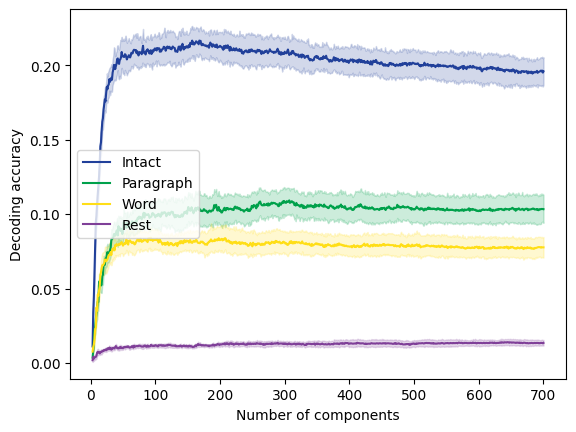

In [ ]:
for c in conditions:
    sns.lineplot(decoding_results['full'][c], x='Number of components', y='Relative decoding accuracy', label=c.capitalize(), color=condition_colors[c])

In [ ]:
for i in range(n_parts):
    fig = plt.figure()

    for c in conditions:
        sns.lineplot(decoding_results[f'pt{i}'][c], x='Number of components', y='Relative decoding accuracy', label=c.capitalize(), color=condition_colors[c])